we numerically encode our images by `[batch-size , height , width , colour channels]`  (NHWC) <br>
or 
`[batch-size, color channel , heught, width]`  (NCHW) color channel can first or last 

## Workflow of how to make a CNN

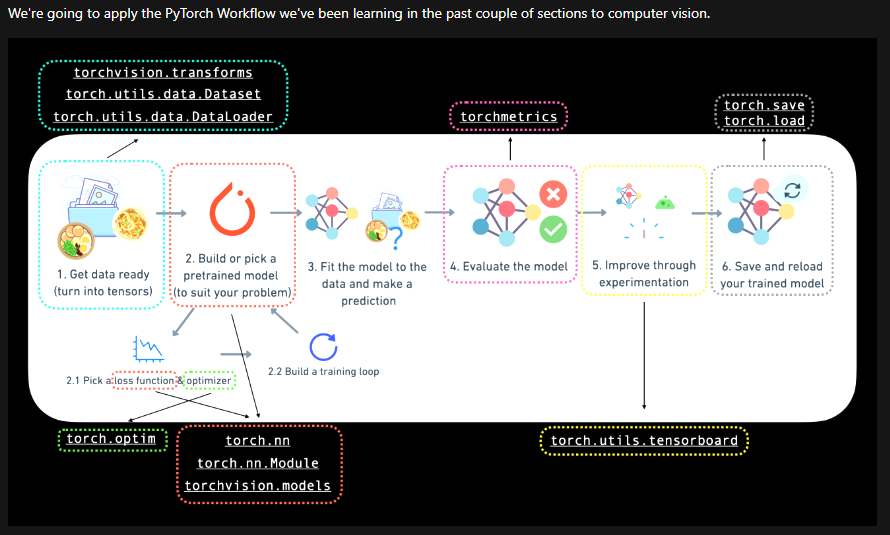

## Things in a CNN Code

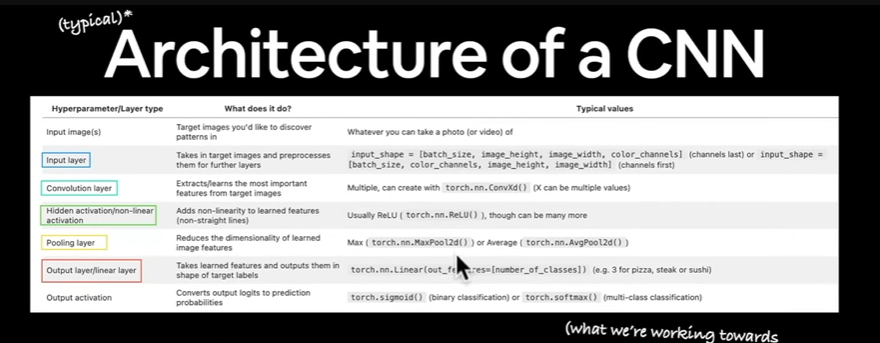


In [1]:

# import torch
# from torch import  nn

# import torchvision

import torch
from torch import nn
import torchvision
from torch.onnx.symbolic_opset11 import unsqueeze
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## 1. Getting a Dataset

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train= True,
    download= True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
image , label = train_data[0]
# image , label

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
image.shape , label

(torch.Size([1, 28, 28]), 9)

### 1.2 Visualizing our data

Img shape torch.Size([1, 28, 28])


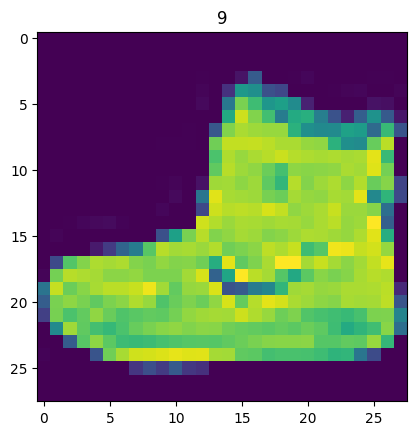

In [7]:
image , label = train_data[0]
print(f"Img shape {image.shape}")
plt.imshow(image.squeeze())
plt.title (label);

* unsqueeze will remove the dimention of size 1 from tensor

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

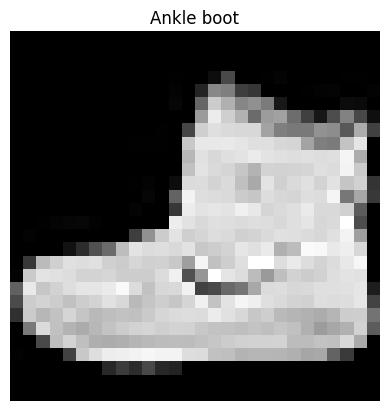

In [8]:
plt.imshow(image.squeeze(),cmap = 'gray')
# plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)

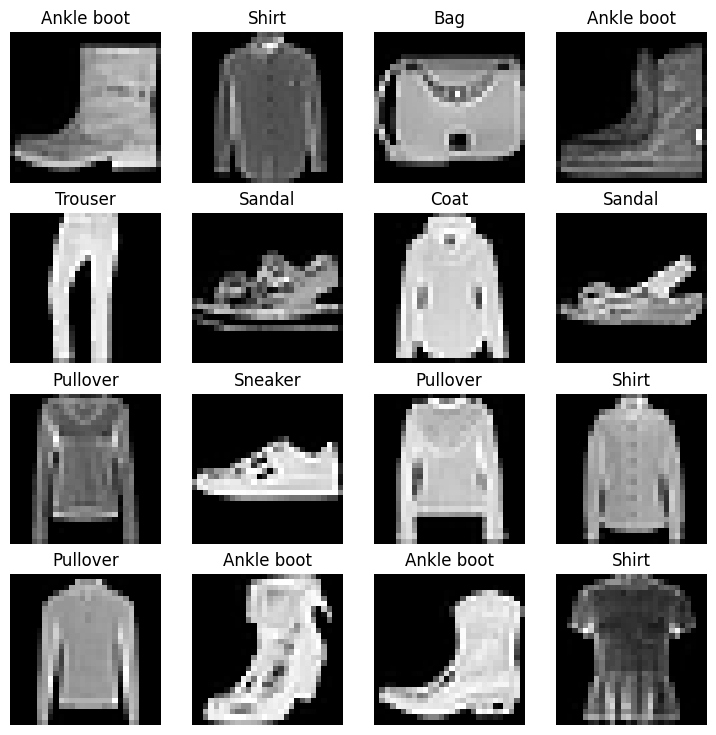

In [9]:
# plot random images
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows , cols = 4,4
for i in range (1 , rows*cols + 1 ):
    # print(i)
    random_idx = torch.randint(0,len(train_data),size = [1]).item()
    # print(random_idx)
    img , label = train_data [ random_idx]
    fig.add_subplot(rows,cols , i)
    plt.imshow(img.squeeze(),cmap = 'gray')
    # plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare Data Loader

dataloader turns our dataset into a python iterable <br>
more specifically, we want to turn our data into batches or mini batches

In [10]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False)

# its not required to shuffle the test data because computer never actually sees the test data
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x170e60b6110>,
 <torch.utils.data.dataloader.DataLoader at 0x170e610a210>)

In [11]:
print(f"Len of train dataloaded : {len(train_dataloader)}")
print(f"Len of test dataloaded : {len(test_dataloader)}")

Len of train dataloaded : 1875
Len of test dataloaded : 313


In [12]:
# see whats inside train data loader
train_feature_batch , train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape,train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Shirt')

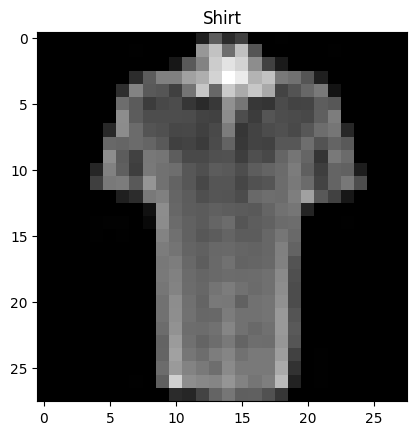

In [13]:
# to show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_feature_batch),size=[1]).item()
img , label = train_feature_batch[random_idx],train_label_batch[random_idx]
plt.imshow (img.squeeze(),cmap = 'gray')
plt.title(class_names[label])


## 3. Model 0 Building a baseline model

In [14]:
# create a flatten layer
flatten_model = nn.Flatten()
x = train_feature_batch[0]
x.shape

# flattten sample
output = flatten_model(x) #basically perform foward pass
print(f"Shape before flatten : {x.shape}")
print(f"Shape after Flatten : {output.shape}")

#

Shape before flatten : torch.Size([1, 28, 28])
Shape after Flatten : torch.Size([1, 784])


Before we had `[Color , height, width]` <br>
after `flatten` we have `[color, height*width]`

flatten basically convert multi dimention input ot 1d vector per sample

In [15]:
from torch import nn
class FashionMNISTModelv0(nn.Module):
    def __init__(self,
                 input_shape : int,
                 hidden_unit : int,
                 output_shape :int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_unit),
            nn.Linear(in_features=hidden_unit,
                      out_features=output_shape)

        )

    def forward(self,x):
        return self.layer_stack(x)



In [16]:
torch.manual_seed(42)
# setup model with input parameters

model0 = FashionMNISTModelv0(
    input_shape=784, #basically 28*28 as of img size
    hidden_unit=10,
    output_shape=len(class_names)
)
model0

FashionMNISTModelv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand([1,1,28,28])
model0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [18]:
# 101 : 15:35:00

### 3.1 Setup Loss, Optimizer and evaluation metrics
* Loss function - we have multiclass data so out loss functn be `nn.crossentropyloss()`
* optimizer - torch.optim.SGD stochastic Gradient Descent
* evaluation - accuracy

In [19]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [20]:
#import accuracy metrics
from helper_functions import  accuracy_fn

#loss fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

### 3.2 making a fucntion to time our experiments

we have to track two things
* Model performance like accuracy loss and vals
* How fast it runs, its efficiency

In [21]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [22]:
start_time = timer()
end_time = timer()
print_train_time(start = start_time,
                 end = end_time,
                 device="cpu")

Train time on cpu: 0.000 seconds


1.570000131323468e-05

### 3.3 creating a training loop on batches on data
1. Loop through epochs
2. Loop through train batch, calculate train loss *per batch*
3. loop through test batch and cal test loss *per batch*
4. print output
5. time it all

In [23]:
# import tqdm #-> basically a progress bar
# from tqdm.auto import tqdm

In [24]:
torch.manual_seed(42)
train_time_start = timer()
epochs = 2

# training and test loop
for epochs in range(epochs):
    print(f"Epochs :{epochs}\n")
    # start Training
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model0.train()
        #forward pass
        y_pred = model0(X)
        # loss
        loss = loss_fn(y_pred,y)
        train_loss = loss +train_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"looked {batch * len(X)}/{len(train_dataloader.dataset)}")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model0.parameters()).device))

Epochs :0

looked 0/60000
looked 12800/60000
looked 25600/60000
looked 38400/60000
looked 51200/60000

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epochs :1

looked 0/60000
looked 12800/60000
looked 25600/60000
looked 38400/60000
looked 51200/60000

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Train time on cpu: 8.993 seconds


## Make predictions and get model 0 results


In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelv0',
 'model_loss': 0.47989004850387573,
 'model_acc': 83.19688498402556}

## Model 1 : model with non linearity

In [26]:


class FashionMNISTModelv1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    # 👇 this must be OUTSIDE __init__, not indented inside it
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


In [28]:
torch.manual_seed(42)
model1 =  FashionMNISTModelv1(input_shape=784,
                               output_shape = len(class_names),
                               hidden_units = 10)
next(model1.parameters())

Parameter containing:
tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
       requires_grad=True)

## 6.1 Setup loss , optimizer and evaluation metrics

In [29]:
from helper_functions import  accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr= 0.1)

### 6.2 Functionzing training and evalution loop

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### get model_1 result dict

In [31]:
model1_result = eval_model(model = model1,
                           data_loader=test_dataloader,
                           loss_fn= loss_fn,
                           accuracy_fn=accuracy_fn)
model1_result

{'model_name': 'FashionMNISTModelv1',
 'model_loss': 2.3107707500457764,
 'model_acc': 10.75279552715655}

In [32]:
model_0_results


{'model_name': 'FashionMNISTModelv0',
 'model_loss': 0.47989004850387573,
 'model_acc': 83.19688498402556}

## Model 2 : Building a CNN
* they are know for their capabilities to find pattern
* The CNN model we're going to be using is known as TinyVGG from the CNN Explainer website.

# Good resourse for Math and intuition and interactive
https://poloclub.github.io/cnn-explainer

### Tiny replica of `VGG` i.e `Visual Geometry Group`

In [37]:
class Modelv2(nn.Module):
    def __init__(self,input_shape: int,
                 hidden_units : int ,
                 output_shape :int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1), #values we can set ourselves are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*0,
                      out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        return x

### terminilogy
* `Padding` adds a bunch of extra pixles around the edges with basically zero val to avoid info loss
* `Stride` The amount of pixels the cnn filter is allowed to skip over in an input image
* `Kernel` A small metrix claled filter that slides over an img to detect specific features like edge or corner
* `MaxPool2d` downsamples an input by taking the maximum value from a rectangular window as it slides across the input

In [38]:
len(class_names)

10

In [39]:
torch.manual_seed(42)
model_2 = Modelv2(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))

C:\Work\Programing Language\Python\Python Libraries\Pytorch\Daniel_one_day_vid\venv\Lib\site-packages\torch\nn\init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## 7.1 Learning abour `Conv2D`


In [40]:
torch.manual_seed(42)
# create batch of images
images = torch.randn(size = (32,3,64,64))
test_img = images[0]

print(f"Img batch shape:{images.shape}")
print(f"Single img shape:{test_img.shape}")


Img batch shape:torch.Size([32, 3, 64, 64])
Single img shape:torch.Size([3, 64, 64])


In [ ]:
# Create simgle conv2d layer
conv_later = nn.COnv2d(in_channels=3,
                       out_channels = 10,
                       kernel_size = (3,3),
                       stride = 1,
                       padding=0)

* `17.51.28`